In [146]:
#question 2 -- downloading the data and processing it

#downloading the data from the given link
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


--2022-12-02 18:27:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘iris.data.2’

iris.data.2         100%[===================>]   4.44K  --.-KB/s    in 0s      

2022-12-02 18:27:52 (92.7 MB/s) - ‘iris.data.2’ saved [4551/4551]



In [147]:
#loading and processing the data

import pandas as pd
def load_data(filepath: str) -> pd.DataFrame:
    """
    This Function reads the file containing data and returns a DataFrame.
  
    Parameters:
    filepath (str): Full path to the file we are reading
  
    Returns:
    pd.DataFrame: returns a DataFrame made from the filepath given.
  
    """

    colnames = ['sepal_length','sepal_width','petal_length','petal_width','class']
    df = pd.read_csv(filepath, names=colnames, header=None)
    class_value = df['class'].to_list()
    for i in range(len(class_value)):
        class_value[i] = 1 if class_value[i]=='Iris-setosa' else 0 
    df['target'] = class_value
    print(sum(class_value))
    return df

df = load_data('iris.data')
df.head()

50


,sepal_length,sepal_width,petal_length,petal_width,class,target
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1


In [148]:
#question 3 - splitting the data

def split(df, train_percent = 0.7, valid_percent = 0.1, test_percent = 0.2):
    
    """
    This Function takes a DataFrame and splits it into train validation and test set 
    using stratified sampling, according to the given percentage.
  
    Parameters:
    df (pd.DataFrame): The dataframe containing all the data.
  
    Returns:
    train: Training dataframe
    valid: validation Dataframe
    test: test dataframe
    """

    pos = df.loc[df['target'] == 1].sample(frac = 1)
    neg = df.loc[df['target'] == 0].sample(frac = 1)

    train_pos = pos.iloc[:int(train_percent*pos.shape[0])]
    valid_pos = pos.iloc[int(train_percent*pos.shape[0]):int((train_percent+valid_percent)*pos.shape[0])]
    test_pos = pos.iloc[int((train_percent+valid_percent)*pos.shape[0]):]
    
    train_neg = neg.iloc[:int(train_percent*neg.shape[0])]
    valid_neg = neg.iloc[int(train_percent*neg.shape[0]):int((train_percent+valid_percent)*neg.shape[0])]
    test_neg = neg.iloc[int((train_percent+valid_percent)*neg.shape[0]):]

    train = pd.concat([train_pos, train_neg])
    valid = pd.concat([valid_pos, valid_neg])
    test = pd.concat([test_pos, test_neg])
    return train.sample(frac = 1), valid.sample(frac = 1), test.sample(frac = 1)

train, valid, test = split(df)

print(train.shape)
print(valid.shape)
print(test.shape)
print(train.shape[0]+valid.shape[0]+test.shape[0])



(105, 6)
(15, 6)
(30, 6)
150


In [149]:
# taking the subset of data we are interested in and making it a  numpy array
import numpy as np

cols = ['petal_length', 'petal_width']
#converting all the data to array
train_x = train[cols].astype('float').to_numpy()
train_y = train[['target']].astype('float').to_numpy()
valid_x = valid[cols].astype('float').to_numpy()
valid_y = valid[['target']].astype('float').to_numpy()

test_x = test[cols].astype('float').to_numpy()
test_y = test[['target']].astype('float').to_numpy()



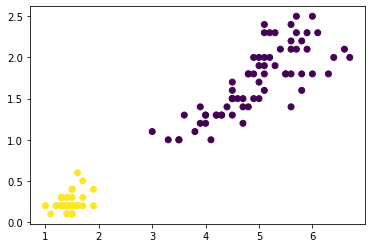

In [150]:
#plotting the data agaionst to column
import matplotlib.pyplot as plt

plt.scatter(train_x[:,0], train_x[:, 1], c=train_y)


In [151]:
#question 4
import numpy as np
np.random.seed(42)

def unison_shuffled_copies(a, b):
    """
    This Function takes two numpy array and shuffles them keeping the corresponding indices same for two array.
  
    Parameters:
    a (np.Array): Array to be shuffled.
    b (np.Array): Array to be shuffled.
    
    Returns:
    a: shuffled copy of a
    b: shuffled copy of b consistent with a
    
    """
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def bce(y, yhat):
    """
    This Function takes two numpy array and computes the binary cross entropy loss between them.
  
    Parameters:
    y (np.Array): original label.
    yhat (np.Array): Predicted Label.
    
    Returns:
    loss: Binary Crossentropy loss among y and yhat
    
    """

    return np.mean(-(y*np.log(yhat)+(1-y)*np.log(1-yhat)))

class LogisticRegressor:
    
    """
    This Class is a representation of logistic regressor.
  
    Attributes
    ----------
    n_features : int
        number of feature the model uses to predict the output
    params : np.array
        parameters to learn for predicting the output 
    age : int
        age of the person
        
    """
    
    def __init__(self, n_features: int = 2):
        """
        This Function initializes all the class parameters.
    
        Parameters:
        n_features (int): number of features the classifiers going to be using
                
        """
        np.random.seed(48) #fixing the seed to have consistent result
        self.params = np.random.randn(n_features + 1)
        self.train_loss_series = []
        self.valid_loss_series = []
        
    def logistic(self, x):
        """
        This Function takes an input and computes the sigmoid function over it.
    
        Parameters:
        x (np.Array or a number): input.
        
        Returns:
        y: sigmoid function over input t
        
        """

        return 1./(1.+np.exp(-x))
    
    def __call__(self, x, params=None, logits=False):

        """
        This Function uses the features and the model parameters to compute the output of the model.
    
        Parameters:
        x (np.Array or a number): input features.
        params : parameters to use for predicting the output
        
        Returns:
        y: model computed prediction (probabilities) over the input features
        
        """
        if params is None:
            params = self.params
        y = params[0] + params[1:] @ x.T
        if not logits:
            y = self.logistic(y)
        return y
    
    def fit(self, train_x, train_y, valid_x, valid_y, epochs: int =100, lr: float = 1e-4):
        # TODO: train the model using gradient descent and finite-differences
        """
        This Function takes the training and validation data and optimizes the model parameters over the train data.
    
        Parameters:
        train_x (np.Array): training features.
        train_y (np.Array): labels of the training data
        valid_x (np.Array): validation features.
        valid_y (np.Array): labels of the validation data.
        epochs (int): number of epochs the optimizer to run.
        lr (float): The learning rate of the optimizer.
        """
        
        self.train_loss_series = []
        self.valid_loss_series = []
        for epoch in range(1, epochs+1):
            train_loss = 0
            valid_loss = 0
            
            h = 0.1
            
            params_grad = 0
            train_x, train_y = unison_shuffled_copies(train_x, train_y)
            for idx, (xi, yi) in enumerate(zip(train_x, train_y)):
                train_loss += bce(yi, self(xi))
                
                #computing the gradients separately for each parameters
                params1_grads = (bce(yi, self(xi, params=self.params+np.array([h, 0 ,0]))) - bce(yi, self(xi)))/h
                params2_grads = (bce(yi, self(xi, params=self.params+np.array([0, h ,0]))) - bce(yi, self(xi)))/h
                params3_grads = (bce(yi, self(xi, params=self.params+np.array([0, 0 ,h]))) - bce(yi, self(xi)))/h                 
                
                #making an array of the gradients to subtract from the previous parameters
                params_grads = np.array([params1_grads, params2_grads, params3_grads])
                self.params = self.params-params_grads*lr
                
            #storing the training loss value
            self.train_loss_series.append(train_loss/train_x.shape[0]) 

            for xi,yi in zip(valid_x, valid_y):
                yhat = self(xi)
                valid_loss += bce(yi, yhat)
            
            #storing the validation loss value
            self.valid_loss_series.append(valid_loss/valid_x.shape[0])

    def predict(self, x, logits=False):
        """
        This Function uses the features and the model parameters to compute the output of the model.
    
        Parameters:
        x (np.Array or a number): input features to predict on.
        
        Returns:
        yhat (np.array): model computed prediction (probabilities) over the input features
        
        """
        yhat = []
        for i in x:
            yhat.append(self(i, logits=False))
        return np.array(yhat)

The classifier parameters are: [ 4.82212194 -1.39851039 -2.01249983]


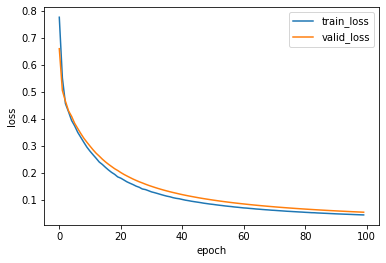

In [152]:
#question 5 - training and visualizing the loss
import matplotlib.pyplot as plt

clf = LogisticRegressor(n_features=train_x.shape[1]) # initializing the classifier
clf.fit(train_x, train_y, valid_x, valid_y, epochs=100, lr=1e-2) #optimize the classifier

print('The classifier parameters are:', clf.params)

plt.plot(clf.train_loss_series, label = 'train_loss') #plot the training loss against epoch
plt.plot(clf.valid_loss_series, label = 'valid_loss') #plot the validation loss against epoch
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.ylabel('loss')

yhat = clf.predict(test_x) #predict on test data

'''
in this case from the plot we can see the model almost slowed down learning after 100 epochs.
It has not overfitted. We can predict that it has over fitted if we see something like the training loss is decreasing
but the validation is not decreasing, rather increasing.
But in this situation it is not the case.
'''

In [153]:
#checking if the predictions have both classes
print((yhat>=0.5).astype(int))  
print(test_y)

[0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [154]:
#question 6

def get_measures(test_y, preds):
    """
    This Function computes the true positive, true negatives, false positive and false negatives 
    from two arrays of true labels and predicted labels.
    
    Parameters:
    test_y (np.Array): true labels.
    preds (np.Array): predicted labels.

    Returns:
    TP (int): True positives 
    TN (int): True negatives
    FP (int): False positives
    FN (int): False negatives       
    """
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(test_y.shape[0]):
        if test_y[i]==1 and preds[i]==1:
            TP+=1
        elif test_y[i]==0 and preds[i]==0:
            TN+=1
        elif test_y[i]==1 and preds[i]==0:
            FN+=1
        elif test_y[i]==0 and preds[i]==1:
            FP+=1

    return TP, TN, FP, FN

TP, TN, FP, FN = get_measures(test_y, yhat>=0.5)
print(f'TP = {TP}, TN = {TN},FP={FP}, FN={FN} ')

TP = 10, TN = 20,FP=0, FN=0 


In [163]:
#question 7 - Calculate the precision and recall and F1 score

def precision(y, yhat):
    # calculate the precision and return it
    """
    This Function computes the precision from two arrays of true labels and predicted labels.
    
    Parameters:
    y (np.Array): true labels.
    yhat (np.Array): predicted labels.

    Returns:
    precision (float): the precision       
    """

    TP, TN, FP, FN = get_measures(y, yhat)
    return TP/(TP+FP)

def recall(y, yhat):
    # calculate the recall and return it
    """
    This Function computes the recall from two arrays of true labels and predicted labels.
    
    Parameters:
    y (np.Array): true labels.
    yhat (np.Array): predicted labels.

    Returns:
    recall (float): the recall       
    """
    
    TP, TN, FP, FN = get_measures(y, yhat)
    return TP/(TP+FN)

def f_beta(y, yhat, beta=1):
    """
    This Function computes the recall from two arrays of true labels and predicted labels.
    
    Parameters:
    y (np.Array): true labels.
    yhat (np.Array): predicted labels.
    beta (int): optional parameter if anyone wants to change the metric from f1. 
    Returns:
    F1 score (float): the recall       
    """

    #get the precision and recall values
    pr = precision(y, yhat>=0.5)
    rc = recall(y, yhat>=0.5)
    
    # calculate the f_beta score and return it
    
    f = (1+beta**2) * (pr*rc)/(pr*beta**2 + rc)
    return f

#print the metrics

pr = precision(test_y, yhat>=0.5)
rc = recall(test_y, yhat>=0.5)
F1_Score = f_beta(test_y, yhat)


print('Precision: ',pr)
print('Recall: ',rc)
print('F1_score: ',F1_Score)


Precision:  1.0
Recall:  1.0
F1_score:  1.0


In [156]:
#Question 8 -- Generating a report

sp = ' '
print(f'|{sp:<9}|{sp:<9}|Predicted|{sp:<9}|')

print(f'|{sp:<9}|{sp:<9}|Positive |Negative |')

print(f'|Actual   |Positive |{TP:<9}|{FN:<9}|')

print(f'|{sp:<9}|Negative |{FP:<9}|{TN:<9}|')
print()
print(f'-Precision: {pr}')
print(f'-Recall: {rc}')
print(f'-Recall: {f_beta(test_y,yhat)}')

|         |         |Predicted|         |
|         |         |Positive |Negative |
|Actual   |Positive |10       |0        |
|         |Negative |0        |20       |

-Precision: 1.0
-Recall: 1.0
-Recall: 1.0


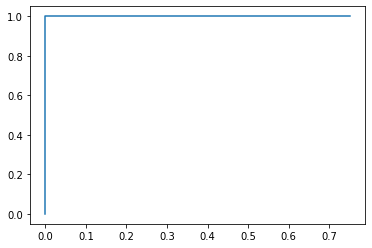

In [157]:
#9 Question 9 -- ROC curve.


def roc(y, yhat, threshold_step=0.01):
    
    """
    This Function computes the True positive and false positive rates to create roc curve 
    from two arrays of true labels and predicted labels.
    
    Parameters:
    y (np.Array): true labels.
    yhat (np.Array): predicted labels.
    threshold_step (flaot): iteratively increase the threshold by threshold_step 
    
    Returns:
    tpr (list): true positive rate
    fpr (list): false positive rate       
    """

    # iteratively increase the threshold by threshold_step,
    # calculating the TP and FP rate for each iteration. This function
    # should return two lists, a list of TP rates, and a list of FP
    # rates.
    
    tpr = []
    fpr = []
    for i in np.arange(0.001, 1, threshold_step):
        TP, TN, FP, FN = get_measures(y, yhat>=i)
        tpr.append(TP/(TP+FN))
        fpr.append(FP/(FP+TN))
    return tpr, fpr


tpr, fpr = roc(test_y, yhat)

# visualise the ROC curve here
plt.plot(fpr, tpr)

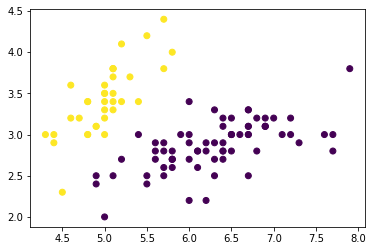

In [158]:
#Question 10 -- selecting data
#selecting the other two columns for the same thing

cols = ['sepal_length','sepal_width']
train_x = train[cols].astype('float').to_numpy()
train_y = train[['target']].astype('float').to_numpy()
valid_x = valid[cols].astype('float').to_numpy()
valid_y = valid[['target']].astype('float').to_numpy()

test_x = test[cols].astype('float').to_numpy()
test_y = test[['target']].astype('float').to_numpy()


plt.scatter(train_x[:,0], train_x[:, 1], c=train_y)

TP = 10, TN = 20,FP=0, FN=0 
Precision 1.0
Recall 1.0
1.0


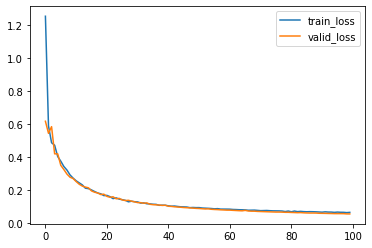

In [159]:
#Question 10 -- training the model with new data

clf = LogisticRegressor(n_features=train_x.shape[1])
clf.fit(train_x, train_y, valid_x, valid_y, epochs=100, lr = 1e-2)
yhat = clf.predict(test_x)

plt.plot(clf.train_loss_series, label = 'train_loss')
plt.plot(clf.valid_loss_series, label = 'valid_loss')

plt.legend(loc = 'best')
TP, TN, FP, FN = get_measures(test_y, yhat>=0.5)
print(f'TP = {TP}, TN = {TN},FP={FP}, FN={FN} ')

pr = precision(test_y, yhat>=0.5)
rc = recall(test_y, yhat>=0.5)

print('Precision',pr)
print('Recall',rc)
print(f_beta(test_y, yhat))

|         |         |Predicted|         |
|         |         |Positive |Negative |
|Actual   |Positive |10       |0        |
|         |Negative |0        |20       |

-Precision: 1.0
-Recall: 1.0
-Recall: 1.0


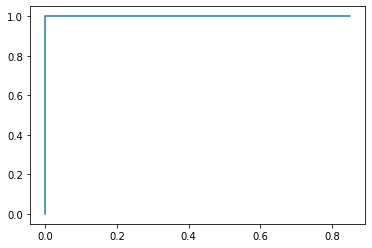

In [160]:
#Question 10 -- Generating a report for the new classifier

sp = ' '
print(f'|{sp:<9}|{sp:<9}|Predicted|{sp:<9}|')

print(f'|{sp:<9}|{sp:<9}|Positive |Negative |')

print(f'|Actual   |Positive |{TP:<9}|{FN:<9}|')

print(f'|{sp:<9}|Negative |{FP:<9}|{TN:<9}|')
print()
print(f'-Precision: {pr}')
print(f'-Recall: {rc}')
print(f'-Recall: {f_beta(test_y,yhat)}')

tp, fp = roc(test_y, yhat)
# visualise the ROC curve here
plt.plot(fp, tp)


'''
from this confusion matrix and the previous one we can see,
for both of them the evaluation metrics are same. so we cannot say one model is better than the other one.
'''